In [128]:
import scipy.io, math, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from utils import *
from nltk.corpus import cmudict
from numpy import linalg as LA
import seaborn as sns
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import Levenshtein

In [2]:
def get_srate(file_number):
    directory = 'data/Data/F5/mat'
    
    # TODO: needs to ignore the .DS_Store file in a better way
    file = sorted(os.listdir(directory))[file_number]
    
    f = os.path.join(directory, file)
    # if this returns a weird error it's because the code also reads the .DS_Store file 
    # in that case, add a +1 behind file_number four lines above this 
    mat = scipy.io.loadmat(f)['usctimit_ema_f5_{:03}_{:03}'.format(file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is awkwardly stored here
    return mat[0][1][1][0][0]

In [3]:
# can't put this in the utils file 
d = cmudict.dict()
def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

In [4]:
def get_pos_list(position, dimension, file_number, starting_point, end_point):
    values = []
    if dimension == 'x':
        dim = 0
    elif dimension == 'y':
        dim = 1 
    elif dimension == 'z':
        dim = 2
    else:
        raise ValueError

    positions = ['UL', 'LL', 'JW', 'TB', 'TD', 'TT']
    dataframes = [UL_df, LL_df, JW_df, TB_df, TD_df, TT_df]
    index = positions.index(position)
    
    for i in range(end_point - starting_point):
        coordinate = (dataframes[index][file_number][dim][starting_point + i])
        if str(coordinate) != 'nan':
            values.append(coordinate)
            
    return np.array(values)

In [5]:
subjects = ['F1', 'F5', 'M1', 'M3']
directory = 'data/Data/{}/mat'.format(subjects[1])
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df = [], [], [], [], [], []

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_{}_{:03}_{:03}'.format(subjects[1].lower(), counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))

In [23]:
frames = {}
sensors = ['ULx', 'ULy', 'LLx', 'LLy', 
           'JWx', 'JWy', 'TDx', 'TDy', 
           'TBx', 'TBy', 'TTx', 'TTy']

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for word_number, line in enumerate(timestamps):
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        
        # find start and end by multiplying the timestamps with the sampling rate
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        end_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # make new dataframe for the current word
        df = pd.DataFrame()
        
        for sensor in sensors:
            array = get_pos_list(sensor[:2], sensor[-1], int(split_line[0]), starting_point, end_point)
            df[sensor] = pd.Series(array)
            df.word = split_line[1]
            df.sent = int(split_line[-1])
            df.syl = nsyl(split_line[1])
            frames[word_number] = df

/var/folders/jz/414l_qjs6s1bndtz3ppcy8cc0000gn/T/ipykernel_42715/48921192.py:24: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.syl = nsyl(split_line[1])


In [24]:
scaler = StandardScaler()

syl1_words, syl2_words, syl3_words = {}, {}, {}
syl4_words, syl5_words, syl6_words = {}, {}, {}

syl_frames = [syl1_words, syl2_words, 
              syl3_words, syl4_words, 
              syl5_words, syl6_words]

for i in range(1, len(syl_frames)+1):
    for count, frame in enumerate(frames):
        # for some reason some words store the number of syllables in an array, hence the try except
        try:
            if frames[frame].syl[0] == i:
                #standardize the data to have a mean of 0 and approx. a SD of 1
                scaler.fit(frames[frame])
                data = scaler.transform(frames[frame])
                df = pd.DataFrame(data)
                
                #set meta-data, at this point we only need the word and the sentence it came from
                df.word = frames[frame].word
                df.sent = frames[frame].sent

                syl_frames[i-1][count] = df
                
        except:
            if frames[frame].syl == i:
                scaler.fit(frames[frame])
                data = scaler.transform(frames[frame])
                df = pd.DataFrame(data)
                
                df.word = frames[frame].word
                df.sent = frames[frame].sent
                
                syl_frames[i-1][count] = df

In [25]:
for frame in syl_frames:
    # target length is the the word with the most samples in that syllable category
    target_length = longest_frame(frame)
    for word in frame:
        current_length = frame[word].shape[0]
        pad_length = int((target_length - current_length)/2)
        
        # add rows to the end of the dataframe
        for i in range(0, pad_length):
            frame[word] = frame[word].append(pd.Series(0, index=df.columns), ignore_index=True)

        # add rows to the start of the dataframe
        df = pd.DataFrame(np.zeros((pad_length, len(sensors))))
        frame[word] = pd.concat([df, frame[word]])
        
        # if the frame had an odd number of rows, the dataframe will be one row too short
        # so here we add one more row if that is the case
        if frame[word].shape[0] < target_length:
            frame[word] = frame[word].append(pd.Series(0, index=df.columns), ignore_index=True)
            
        frame[word] = frame[word].reset_index(drop=True)    
        
        # not sure if transposing is necessary, but they did this in the paper i used as inspiration
        # so i'll keep it consistent with that paper
        new = frame[word].transpose()
        frame[word] = new

In [34]:
difference_matrix_1, difference_matrix_2, difference_matrix_3 = [], [], []
difference_matrix_4, difference_matrix_5, difference_matrix_6 = [], [], []

difference_matrices = [difference_matrix_1, difference_matrix_2, 
                       difference_matrix_3, difference_matrix_4, 
                       difference_matrix_5, difference_matrix_6]

for i, matrix in enumerate(syl_frames):
    for row_word in syl_frames[i]:
        row = np.array([])
        for column_word in syl_frames[i]:
            difference_matrix = syl_frames[i][row_word].subtract(syl_frames[i][column_word])
            matrix = difference_matrix.to_numpy()
            
            frob_norm = linalg.norm(matrix)

            row = np.append(row, frob_norm)

        difference_matrices[i].append(row)
    

In [38]:
syl5 = []
for frame in syl5_words:
    syl5.append(frame)
    
labels = []
for i in syl5:
    labels.append(frames[i].word)

In [39]:
diff5 = np.array([difference_matrix_5])
df = pd.DataFrame(diff5[0])
df.columns, df.index = labels, labels

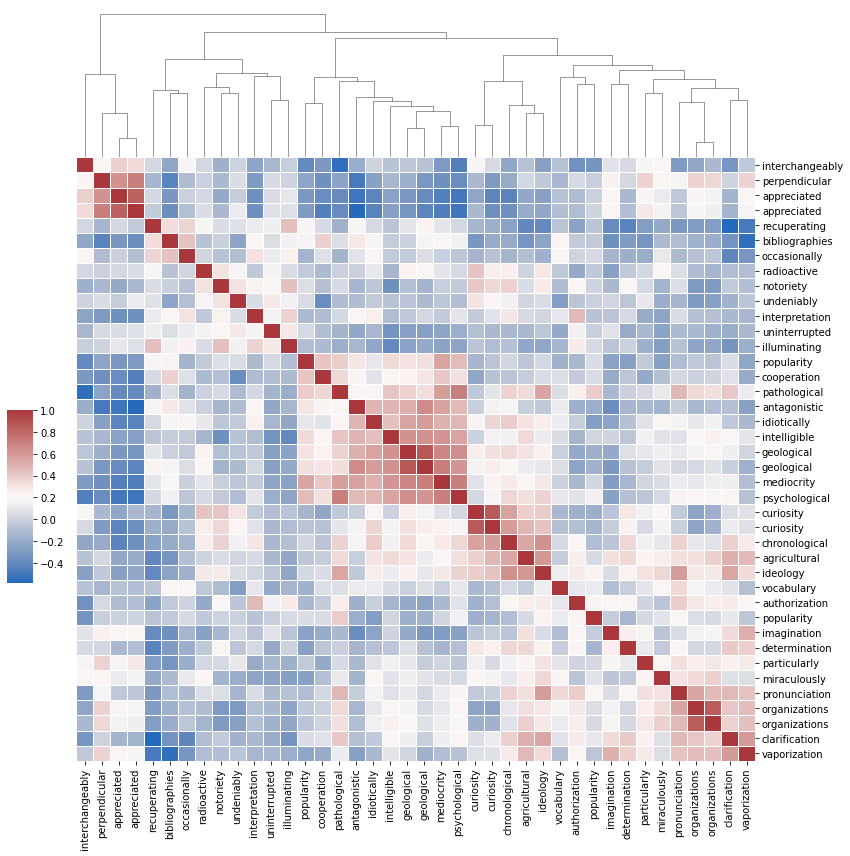

In [51]:
correlations = df.corr()
correlations_array = np.asarray(df.corr())

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

clustermap = sns.clustermap(correlations, row_linkage=row_linkage, 
                            col_linkage=col_linkage, 
                            dendrogram_ratio=(.1, .2),
                            method="average",
                            cbar_pos=(.02, .32, .03, .2),
                            linewidths=1, figsize=(12, 12), 
                            cmap='vlag')

clustermap.ax_row_dendrogram.remove()



#plt.savefig('test.png')

In [140]:
clusters = hierarchy.fcluster(row_linkage, t=1)
zipped = tuple(zip(clusters, labels))

syl5_clusters = {}

for pair in zipped:
    if pair[0] in syl5_clusters:
        syl5_clusters[pair[0]].append(pair[1])
    else:
        syl5_clusters[pair[0]] = [pair[1]]

In [141]:
vals = list(syl5_clusters.values())

In [142]:
Levenshtein.setmedian(vals[4])

'illuminating'

In [143]:
vals

[['popularity', 'cooperation'],
 ['vocabulary', 'authorization', 'popularity'],
 ['appreciated', 'appreciated', 'perpendicular', 'interchangeably'],
 ['geological', 'geological'],
 ['uninterrupted',
  'notoriety',
  'bibliographies',
  'radioactive',
  'occasionally',
  'illuminating',
  'undeniably',
  'recuperating',
  'interpretation'],
 ['imagination', 'determination'],
 ['agricultural', 'chronological', 'ideology'],
 ['clarification', 'vaporization'],
 ['curiosity', 'curiosity'],
 ['mediocrity', 'psychological'],
 ['pathological'],
 ['pronunciation', 'organizations', 'organizations'],
 ['intelligible'],
 ['idiotically'],
 ['antagonistic'],
 ['particularly', 'miraculously']]